# Fine-Scale Prediction of People's Home Location using Social Media Footprints

_**Authors:** Hamdi Kavak, Daniele Vernon-Bido, and Jose Padilla_

_**Submitted:** SBP-BRIMS 2018 on January 11, 2018._

## DBSCAN Clustering Distance Resolution Test

#### - Imports

In [1]:
### Home Location Prediction Paper ###########
# Task: Home location DBSCAN resolution test
# Author: Hamdi Kavak
# Created: December 27, 2017
#########################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from datetime import timedelta
from scipy import stats

#### - CONSTANTS

In [2]:
METER_PER_RADIAN = 6371000.0088
DISTANCE_RESOLUTION_IN_METER = 100
TIME_RESOLUTION_IN_MINUTES = 60

#### - Functions

In [3]:
def clean_location_footprints(data):
    # making sure there is enough data
    if len(data) < 2:
        return data

    # the remaining lines below looks consecutive tweets to make sure 
    #       they are not sent from the same place within a short timeframe'
    #       because it will introduce biases in the machine learning model.
    
    user_index_values = data.index.values
    indexes_to_drop = []
    first_item = data.iloc[0,:]

    for i in range(1,len(data)-1):

        second_item = data.iloc[i,:]

        time_diff = second_item['local_datetime']-first_item['local_datetime']
        time_diff_in_minutes = time_diff / np.timedelta64(1, 'm')

        first_point = (first_item['latitude'], first_item['longitude'])
        second_point = (second_item['latitude'], second_item['longitude'])

        distance_in_meters = great_circle(first_point, second_point).meters

        if time_diff_in_minutes < TIME_RESOLUTION_IN_MINUTES and second_item['home_confirmed'] == 'f' and distance_in_meters < DISTANCE_RESOLUTION_IN_METER:
            indexes_to_drop.append (i)
        else:
            first_item = second_item

    data = data.drop(data.index[indexes_to_drop])
    
    return data

# original https://stackoverflow.com/a/1518632/80738
def get_most_common(lst):
    return max(set(lst), key=lst.count)

#### - Load data

In [4]:
## all_data.csv contains anonymized ~1.2 million tweets from 1268 users
parse_dates = ['utc_datetime', 'local_datetime']
df = pd.read_csv('all_data.csv',low_memory=False, parse_dates=parse_dates)

df.sort_values('id',inplace=True)

## We use only one users' data to generate machine learning model attributes
##   after getting this done, other users will be quite straigtforward.

num_of_rows = len(df.index)
print num_of_rows, ' rows loaded.'

1222971  rows loaded.


#### - Iterate through users and record the distance among home-labeled clusters and to the centroid

In [5]:
# record all distances
distances_among_checkins = []
distances_to_centroid = []
distances_among_checkins_avg = []
distances_to_centroid_avg = []

unique_user_ids = df.user_id.unique()

for selected_user_id in unique_user_ids:
    
    # get only data from this user
    df_user = df.loc[df['user_id'] == selected_user_id] 
    
    # clean data for repeated entries
    df_user = clean_location_footprints(df_user) 
    
    # apply clustering algorithm to enhance data further
    coords = df_user.as_matrix(columns=['latitude', 'longitude'])
    epsilon = DISTANCE_RESOLUTION_IN_METER / METER_PER_RADIAN
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    
    # add cluster IDs as a property called 'label'
    df_user = df_user.assign(label=pd.Series(cluster_labels).values)
    
    # mark check-ins that is confirmed as home
    home_confirmed_checkins = df_user.loc[df_user['home_confirmed'] == 't']
    
    # there is a possibility that home checkins will be assigned to multiple clusters
    # we chose the most commonly seen one
    home_label = get_most_common(home_confirmed_checkins['label'].tolist())
    
    # find all home checkins
    all_home_checkins = df_user.loc[df_user['label'] == home_label]
    home_cluster_centroid = (all_home_checkins['latitude'].mean(), all_home_checkins['longitude'].mean())
    
    
    # get a sample with up to 50 home location checkins
    sample_size = 50
    data_size = len(all_home_checkins.index)
    
    if data_size > 1:
    
        sample_home_checkins = all_home_checkins.sample(sample_size) if data_size > sample_size else all_home_checkins

        distances_among_checkins_temp = []
        distances_to_centroid_temp = []
        # calculate the distance among home checkins
        # j and j index is used to eliminate unnecessary repetitions
        i = 0
        for ind1, row1 in sample_home_checkins.iterrows(): 

            first_point = (row1['latitude'], row1['longitude'])
            j = 0

            for ind2, row2 in sample_home_checkins.iterrows():
                if j > i:

                    second_point = (row2['latitude'], row2['longitude'])

                    distance_in_meters = great_circle(first_point, second_point).meters
                    distances_among_checkins.append(distance_in_meters)
                    distances_among_checkins_temp.append(distance_in_meters)
                j = j + 1

            i = i + 1


        for ind, row in all_home_checkins.iterrows(): 
            # calculate the distance against the centroid
            first_point = (row['latitude'], row['longitude'])
            distance_in_meters = great_circle(first_point, home_cluster_centroid).meters
            distances_to_centroid.append(distance_in_meters)
            distances_to_centroid_temp.append(distance_in_meters)

        distances_among_checkins_avg.append(np.mean(distances_among_checkins_temp))
        distances_to_centroid_avg.append(np.mean(distances_to_centroid_temp))
    

print 'Number of among-cluster check-in distances: ', len(distances_among_checkins)
print 'Number of centroid-based check-in distances', len (distances_to_centroid)

Number of among-cluster check-in distances:  1065523
Number of centroid-based check-in distances 238288


#### - Distances among check-ins

Mean:  44.9466059511  - Median :  15.3627336417  - Std. dev.:  105.551205751


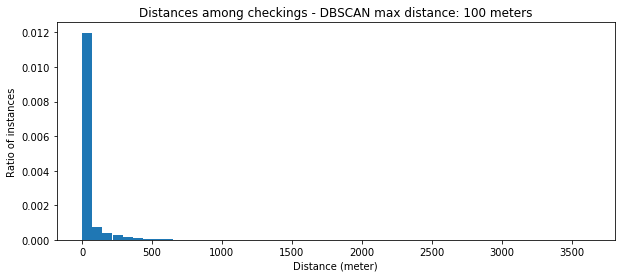

In [12]:
print 'Mean: ', np.mean(distances_among_checkins), ' - Median : ', np.median(distances_among_checkins), ' - Std. dev.: ', np.std(distances_among_checkins)
plt.figure(figsize=(10,4))
plt.hist(distances_among_checkins, bins=50, normed=True)
plt.title('Distances among checkings - DBSCAN max distance: ' + str(DISTANCE_RESOLUTION_IN_METER) + ' meters')
plt.xlabel('Distance (meter)')
plt.ylabel('Ratio of instances')
plt.show()

#### - Distances between check-ins and cluster centroid

Mean:  50.9353743751  - Median :  15.4253554779  - Std. dev.:  105.055535234


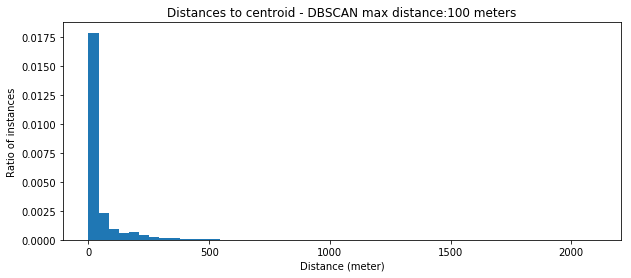

In [14]:
print 'Mean: ', np.mean(distances_to_centroid), ' - Median : ', np.median(distances_to_centroid), ' - Std. dev.: ', np.std(distances_to_centroid)
plt.figure(figsize=(10,4))
plt.hist(distances_to_centroid, bins=50, normed=True)
plt.title('Distances to centroid - DBSCAN max distance:' + str(DISTANCE_RESOLUTION_IN_METER) + ' meters')
plt.xlabel('Distance (meter)')
plt.ylabel('Ratio of instances')
plt.show()

#### - ... same test w/ averages

Mean:  40.0130467879  - Median :  20.8643033369  - Std. dev.:  65.2363184551


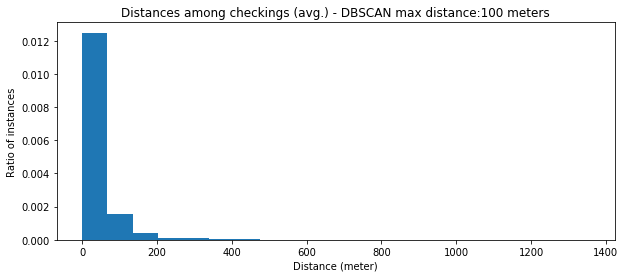

Mean:  28.8697522322  - Median :  14.4787045072  - Std. dev.:  48.3737235329


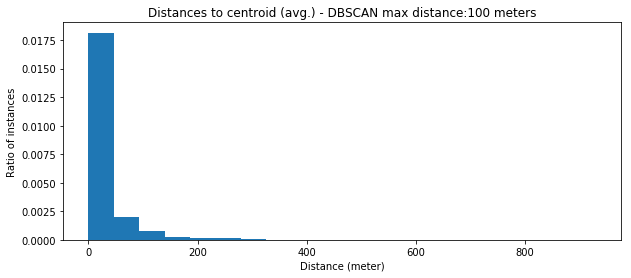

In [15]:
print 'Mean: ', np.mean(distances_among_checkins_avg), ' - Median : ', np.median(distances_among_checkins_avg), ' - Std. dev.: ', np.std(distances_among_checkins_avg)
plt.figure(figsize=(10,4))
plt.hist(distances_among_checkins_avg, bins=20, normed=True)
plt.title('Distances among checkings (avg.) - DBSCAN max distance:' + str(DISTANCE_RESOLUTION_IN_METER) + ' meters')
plt.xlabel('Distance (meter)')
plt.ylabel('Ratio of instances')
plt.show()


print 'Mean: ', np.mean(distances_to_centroid_avg), ' - Median : ', np.median(distances_to_centroid_avg), ' - Std. dev.: ', np.std(distances_to_centroid_avg)
plt.figure(figsize=(10,4))
plt.hist(distances_to_centroid_avg, bins=20, normed=True)
plt.title('Distances to centroid (avg.) - DBSCAN max distance:' + str(DISTANCE_RESOLUTION_IN_METER) + ' meters')
plt.xlabel('Distance (meter)')
plt.ylabel('Ratio of instances')
plt.show()